In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from pprint import pprint
import collections

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install gym
!pip install gym-minigrid
!pip install stable-baselines3[extra]

     |████████████████████████████████| 48 kB 4.7 MB/s 
     |████████████████████████████████| 177 kB 28.1 MB/s 
     |████████████████████████████████| 1.5 MB 48.6 MB/s 
     |████████████████████████████████| 1.6 MB 45.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616823 sha256=f53d31336fccac5252d9c17adc6c5aca12c5ef48c811ac85c9752b66529dae1e
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=56e6c8284630d1170a454ed12a6907951c900d889d5193e142ddfee6264d08b6
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built gym AutoROM.accept-rom-license
  Attempting uninstall: gym
    Found exis

In [ ]:
# import movinggoals_standard_board as go
import movinggoals as go
# import movinggoals_quad as go
import gym
import gym_minigrid
from gym import spaces
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX

from gym.wrappers import Monitor
from utils import show_video

import stable_baselines3
from stable_baselines3 import A2C, PPO, DQN
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

import os
import shutil

from zipfile import ZipFile

import torch

In [ ]:
max_env_steps = 500

class FlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.
        
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            dtype='uint8'
        )
        self.unwrapped.max_steps = max_env_steps

    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)
        
        flattened_grid = full_grid.ravel()
        return flattened_grid
    
    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        kwargs['highlight'] = False
        return self.unwrapped.render(*args, **kwargs)

# Monitor is a gym wrapper, which helps easy rendering of videos of the wrapped environment.
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def gen_wrapped_env(env):
    return wrap_env(FlatObsWrapper(env))

In [ ]:
class MotivatedAgent():
    def __init__(self, env, visited_prob=0.75, optimistic_reward=1, motivation_level=1):
      self.previous_reward = -float('inf')
      self.optimistic_reward = optimistic_reward
      self.previous_action = env.action_space.sample()

      self.env = env

      self.n_action = len(env.actions)
      self.cur_pos = env.agent_pos
      self.visited_goals = []
      self.visited_prob= visited_prob

      self.rewards = {}
      self.motivation_level = motivation_level

      self.frequency = [0]*self.n_action
      self.target = None

    def predict(self, obs, deterministic):
      self.cur_pos = self.env.agent_pos

      potential_action = self.__suggest_action(self.previous_action)

      if self.previous_action in self.visited_goals and potential_action in self.visited_goals:
        r_target = self.rewards[self.previous_action]
        r_potential = self.rewards[potential_action]
          
      elif self.previous_action in self.visited_goals and potential_action not in self.visited_goals:

        r_target = self.rewards[self.previous_action]
        r_potential = self.optimistic_reward

      elif self.previous_action not in self.visited_goals and potential_action in self.visited_goals:

        r_target = self.optimistic_reward
        r_potential = self.rewards[potential_action]

      elif self.previous_action not in self.visited_goals and potential_action not in self.visited_goals:
        r_target = self.optimistic_reward
        r_potential = self.optimistic_reward

      if r_target / self.get_distance(self.previous_action, self.cur_pos) >= r_potential / self.get_distance(potential_action, self.cur_pos):
    
        return self.previous_action, r_target / self.get_distance(self.previous_action, self.cur_pos)
  
      return potential_action, r_potential / self.get_distance(potential_action, self.cur_pos)


    def get_distance(self, action, state):
      x_diff_target, y_diff_target = tuple(map(lambda i, j: i - j, self.env.actions[action].cur_pos, state))
      return abs(x_diff_target) + abs(y_diff_target)


    def __suggest_action(self, previous_action):
      # if you want to always give a goal that is not the current target goal
      if np.random.rand() < self.visited_prob and self.visited_goals:
        if len(self.visited_goals) == 1 and previous_action == self.visited_goals[0]:
          return self.env.action_space.sample()
          return action

        while True:
          idx = np.random.choice(len(self.visited_goals))
          action = self.visited_goals[idx]
          
          if previous_action != action:
            return action
        
      else:
        return self.env.action_space.sample()

    def learn(self, action, reward):
      self.previous_action = action
      self.previous_reward = reward
      if reward != 0:
        self.frequency[action] += 1
        if action not in self.visited_goals:
        
        # initial update
          if self.visited_goals == []:
            reward = self.motivation_level*reward
            self.target = action
          self.visited_goals.append(action)
          self.rewards[action] = reward
        
        

In [ ]:
def run_agent(learning_steps, training_iterations, max_steps, percent_zero, model, visited_prob=False, motivation_level=1, optimistic_reward=False):

  all_rewards = []

  env = go.GoEnv(percent_zero=percent_zero)
  env = gen_wrapped_env(env)
  obs = env.reset()
  # print(env.object_reward)

  v=0.75
  o=1
  ml = 1
  if model == 'm':
    if visited_prob:
      v = visited_prob
    if optimistic_reward:
      o = optimistic_reward
    if motivation_level:
      ml = motivation_level
    model = MotivatedAgent(env, visited_prob=v, optimistic_reward=o, motivation_level=ml)

  for iter in range(training_iterations):

    rewards = []
    exp_rew = []
    actions = []
    state = []
    imgs = []

    for step in range(learning_steps):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        model.learn(action, reward)

    for step in range(max_steps):
        action, _states = model.predict(obs, deterministic=True)
        exp_rew.append(_states)
        obs, reward, done, info = env.step(action)
        
        rewards.append(reward)
        state.append(env.agent_pos)
        actions.append(action)
        
    all_rewards.append(rewards)
  
  env.close()

  all_rewards = np.array(all_rewards)
  all_rewards = all_rewards.mean(axis=1)
  return all_rewards, model.frequency, model.target

In [ ]:
learning_steps = 1
training_iterations = 100
max_steps = 20
percent_zero = 0
learning_rate = 1

In [ ]:
model = 'm'
motivated_rewards, action_rewards, target = run_agent(learning_steps=learning_steps, training_iterations=training_iterations, max_steps=max_steps, percent_zero=percent_zero, model=model, visited_prob=0, optimistic_reward=1, motivation_level=0.5)

/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py:87: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  "Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users."
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in long_scalars


Text(0, 0.5, 'Frequency')

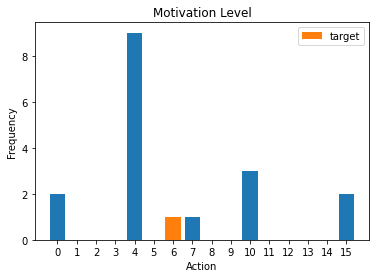

In [ ]:
# action_frequency = collections.Counter(action_rewards)
# print(action_frequency)
plt.bar(list(map(str,np.arange(len(action_rewards)))), action_rewards)
plt.bar(str(target), action_rewards[target], label = "target")
# print(list(map(str,np.arange(len(action_rewards)))), action_rewards)
plt.legend()
plt.title("Motivation Level")
plt.xlabel('Action')
plt.ylabel('Frequency')

Text(0, 0.5, 'Average Reward')

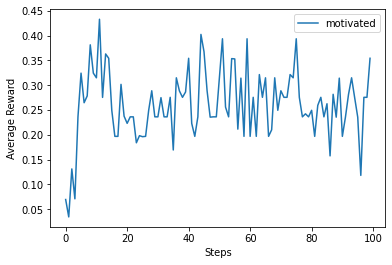

In [ ]:
# plt.plot(optimal_rewards, label = 'optimal')
plt.plot(motivated_rewards, label = 'motivated')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Average Reward')

In [ ]:
def run_one_agent(model, env, max_steps):
  rewards = []
  obs = env.reset()
  for i in range(max_steps):
      action, _states = model.predict(obs, deterministic=True)
      obs, reward, done, info = env.step(action)
      rewards.append(reward)

      if done:
        obs = env.reset()

  env.close()
  # show_video()

  return rewards

In [ ]:
def run_a2c_agent(save_frequency, iterations, max_steps, percent_zero=0, learning_rate=0.0007, ent=0.01):

  if os.path.exists('./logs/'):
    shutil.rmtree('./logs/')
    
  os.makedirs('./logs/')

  env = go.GoEnv(percent_zero=percent_zero)
  env = gen_wrapped_env(env)

  a2c_model = A2C("MlpPolicy", env, verbose=0, learning_rate=learning_rate, ent_coef=ent, n_steps=1)
  checkpoint_callback = CheckpointCallback(save_freq=save_frequency, save_path='./logs/', name_prefix='a2c_model')
  a2c_model.learn(total_timesteps=iterations, callback=checkpoint_callback)

  model_number = save_frequency

  total_rewards = []

  while model_number < iterations:

    filename = 'logs/a2c_model_' + str(model_number) + '_steps.zip'

    env = go.GoEnv(percent_zero=percent_zero)
    env = FlatObsWrapper(env)

    with ZipFile(filename, 'r') as zip:
      zip.extract('policy.pth')
      state_dictionary = torch.load('policy.pth')
      a2c_model = A2C("MlpPolicy", env, verbose=0)
      a2c_model.policy.load_state_dict(state_dictionary, strict = True)

    total_rewards.append(run_one_agent(a2c_model, env, max_steps=max_steps))
    model_number += save_frequency 

  total_rewards = np.array(total_rewards)
  total_rewards = np.mean(total_rewards, axis = 1)

  return total_rewards

In [ ]:
a2c_rewards = run_a2c_agent(learning_steps, training_iterations, max_steps, learning_rate=1, ent=0)


/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py:87: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  "Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users."


/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py:87: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  "Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users."


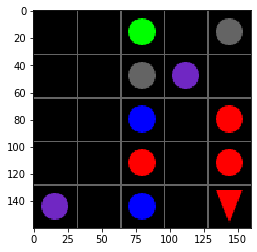

In [ ]:
env = go.GoEnv(percent_zero=percent_zero)

env = gen_wrapped_env(env)
env2 = env
env3 = env2

render = lambda : plt.imshow(env.render(mode='rgb_array'))
env.reset()
render()

a2c_model = A2C("MlpPolicy", env, verbose=0, learning_rate=learning_rate, ent_coef=0.01, n_steps=1)
a2c_model.learn(total_timesteps=100)


/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py:87: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  "Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users."


NameError: ignored

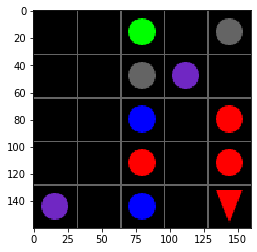

In [ ]:
env = go.GoEnv(percent_zero=percent_zero)

env = gen_wrapped_env(env)

render = lambda : plt.imshow(env.render(mode='rgb_array'))
env.reset()
render()

v=0.75
o=1
model = MotivatedAgent(env, visited_prob=v, optimistic_reward=o)
# print(training_iterations)
for iter in range(100):

  rewards = []
  exp_rew = []
  actions = []
  state = []
  imgs = []

  for step in range(learning_steps):
      action, _states = model.predict(obs, deterministic=True)
      obs, reward, done, info = env.step(action)
      model.learn(action, reward)

In [ ]:
video_folder = 'logs/videos/'
video_length = 100

env = go.GoEnv(percent_zero=percent_zero)
env = gen_wrapped_env(env)
env = DummyVecEnv([lambda: env])

obs = env.reset()

# Record the video starting at the first step
env = VecVideoRecorder(env, video_folder,
                       record_video_trigger=lambda x: x == 0, video_length=video_length)

env.reset()
for _ in range(video_length + 1):
  action = [env.action_space.sample()]
  obs, _, _, _ = env.step(action)
# Save the video
env.close()

/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py:87: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  "Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users."


Saving video to /content/logs/videos/rl-video-step-0-to-step-100.mp4


Text(0, 0.5, 'Average Reward')

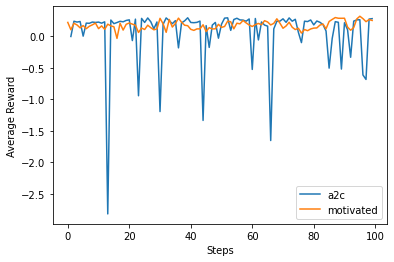

In [ ]:
plt.plot(np.arange(learning_steps, training_iterations, learning_steps), a2c_rewards, label='a2c')
plt.plot(motivated_rewards, label='motivated')
# plt.plot(optimal_rewards, label='optimal')

plt.legend()
plt.xlabel('Steps')
plt.ylabel('Average Reward')

In [ ]:
def run_ppo_agent(save_frequency, iterations, max_steps, percent_zero=0, learning_rate=0.0007, ent=0.01):

  if os.path.exists('./logs/'):
    shutil.rmtree('./logs/')
    
  os.makedirs('./logs/')

  env = go.GoEnv(percent_zero=percent_zero)
  env = gen_wrapped_env(env)

  ppo_model = PPO("MlpPolicy", env, verbose=0, learning_rate=learning_rate, ent_coef=ent)
  checkpoint_callback = CheckpointCallback(save_freq=save_frequency, save_path='./logs/', name_prefix='ppo_model')
  ppo_model.learn(total_timesteps=iterations, callback=checkpoint_callback)

  model_number = save_frequency

  total_rewards = []

  while model_number < iterations:

    filename = 'logs/ppo_model_' + str(model_number) + '_steps.zip'

    env = go.GoEnv(percent_zero=percent_zero)
    env = FlatObsWrapper(env)

    with ZipFile(filename, 'r') as zip:
      zip.extract('policy.pth')
      state_dictionary = torch.load('policy.pth')
      ppo_model = PPO("MlpPolicy", env, verbose=0)
      ppo_model.policy.load_state_dict(state_dictionary, strict = True)

    total_rewards.append(run_one_agent(ppo_model, env, max_steps=max_steps))
    model_number += save_frequency 

  total_rewards = np.array(total_rewards)
  total_rewards = np.mean(total_rewards, axis = 1)

  return total_rewards

In [ ]:
ppo_rewards = run_ppo_agent(learning_steps, training_iterations, max_steps, learning_rate=1, ent=0)


/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py:87: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  "Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users."


Text(0, 0.5, 'Average Reward')

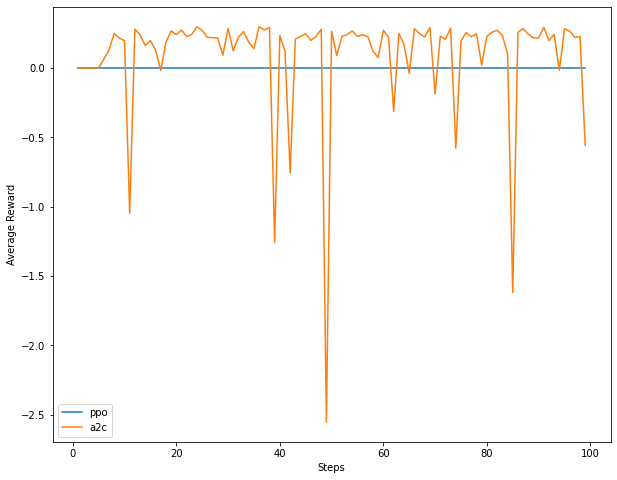

In [ ]:
plt.plot(np.arange(learning_steps, training_iterations, learning_steps), ppo_rewards, label='ppo')
plt.plot(np.arange(learning_steps, training_iterations, learning_steps), a2c_rewards, label='a2c')

plt.legend()
plt.xlabel('Steps')
plt.ylabel('Average Reward')

In [ ]:
def run_dqn_agent(save_frequency, iterations, max_steps, percent_zero=0, learning_rate=0.0007, ent=0.01):

  if os.path.exists('./logs/'):
    shutil.rmtree('./logs/')
    
  os.makedirs('./logs/')

  env = go.GoEnv(percent_zero=percent_zero)
  env = gen_wrapped_env(env)

  dqn_model = DQN("MlpPolicy", env, verbose=0, learning_rate=learning_rate)
  checkpoint_callback = CheckpointCallback(save_freq=save_frequency, save_path='./logs/', name_prefix='dqn_model')
  dqn_model.learn(total_timesteps=iterations, callback=checkpoint_callback)

  model_number = save_frequency

  total_rewards = []

  while model_number < iterations:

    filename = 'logs/dqn_model_' + str(model_number) + '_steps.zip'

    env = go.GoEnv(percent_zero=percent_zero)
    env = FlatObsWrapper(env)

    with ZipFile(filename, 'r') as zip:
      zip.extract('policy.pth')
      state_dictionary = torch.load('policy.pth')
      dqn_model = DQN("MlpPolicy", env, verbose=0)
      dqn_model.policy.load_state_dict(state_dictionary, strict = True)

    total_rewards.append(run_one_agent(dqn_model, env, max_steps=max_steps))
    model_number += save_frequency 

  total_rewards = np.array(total_rewards)
  total_rewards = np.mean(total_rewards, axis = 1)

  return total_rewards

In [ ]:
dqn_rewards = run_dqn_agent(learning_steps, training_iterations, max_steps)


/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py:87: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  "Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users."


Text(0, 0.5, 'Average Reward')

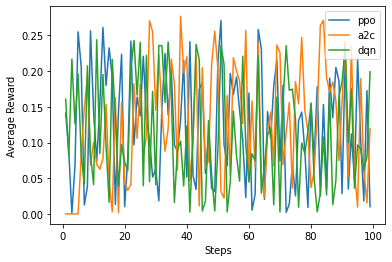

In [ ]:
plt.plot(np.arange(learning_steps, training_iterations, learning_steps), ppo_rewards, label='ppo')
plt.plot(np.arange(learning_steps, training_iterations, learning_steps), a2c_rewards, label='a2c')
plt.plot(np.arange(learning_steps, training_iterations, learning_steps), dqn_rewards, label='dqn')

plt.legend()
plt.xlabel('Steps')
plt.ylabel('Average Reward')

In [ ]:
def run_multiple(episodes, percent_zero=0, learning_rate=0.0007, ent=0.01):
  m_rewards_all = []
  o_rewards_all = []
  a2c_rewards_all = []
  ppo_rewards_all = []
  dqn_rewards_all = []

  for i in range(episodes):
    motivated_rewards = run_agent(learning_steps=learning_steps, training_iterations=training_iterations, max_steps=max_steps, percent_zero=percent_zero, model='m')
    # optimal_rewards = run_agent(learning_steps=learning_steps, training_iterations=training_iterations, max_steps=max_steps, percent_zero=percent_zero, model='o')
    a2c_rewards = run_a2c_agent(learning_steps, training_iterations, max_steps, percent_zero=percent_zero, learning_rate=learning_rate, ent=ent)
    # ppo_rewards = run_ppo_agent(learning_steps, training_iterations, max_steps, learning_rate=1, ent=ent)
    # dqn_rewards = run_dqn_agent(learning_steps, training_iterations, max_steps, learning_rate=1, ent=ent)

    m_rewards_all.append(motivated_rewards)
    # o_rewards_all.append(optimal_rewards)
    a2c_rewards_all.append(a2c_rewards)
    # ppo_rewards_all.append(ppo_rewards)
    # dqn_rewards_all.append(dqn_rewards)

  return m_rewards_all, o_rewards_all, a2c_rewards_all, ppo_rewards_all, dqn_rewards_all

In [ ]:
learning_steps = 1
training_iterations = 100
max_steps = 100
percent_zero = 0
learning_rate = 1
ent = 0.01

In [ ]:
m_rewards_all, o_rewards_all, a2c_rewards_all, ppo_rewards_all, dqn_rewards_all = run_multiple(episodes=5, percent_zero=percent_zero, learning_rate=learning_rate)

/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py:87: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  "Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users."
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py:87: UserWarning: WARN: Trying to mo

In [ ]:
m_rewards_all = np.array(m_rewards_all).mean(axis=0)
o_rewards_all = np.array(o_rewards_all).mean(axis=0)
a2c_rewards_all = np.array(a2c_rewards_all).mean(axis=0)
ppo_rewards_all = np.array(ppo_rewards_all).mean(axis=0)
dqn_rewards_all = np.array(dqn_rewards_all).mean(axis=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """


Text(0, 0.5, 'Average Reward')

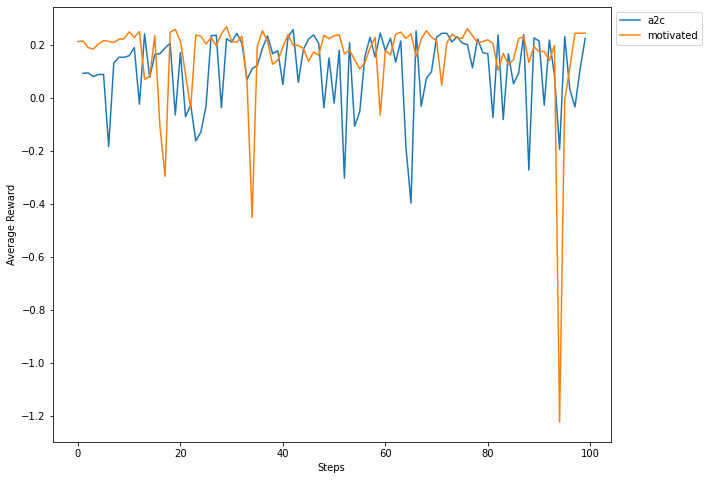

In [ ]:
plt.plot(np.arange(learning_steps, training_iterations, learning_steps), a2c_rewards_all, label='a2c')
# plt.plot(np.arange(learning_steps, training_iterations, learning_steps), ppo_rewards_all, label='ppo')
# plt.plot(np.arange(learning_steps, training_iterations, learning_steps), dqn_rewards_all, label='dqn')
plt.plot(m_rewards_all, label='motivated')
# plt.plot(o_rewards_all, label='optimal')

plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Steps')
plt.ylabel('Average Reward')

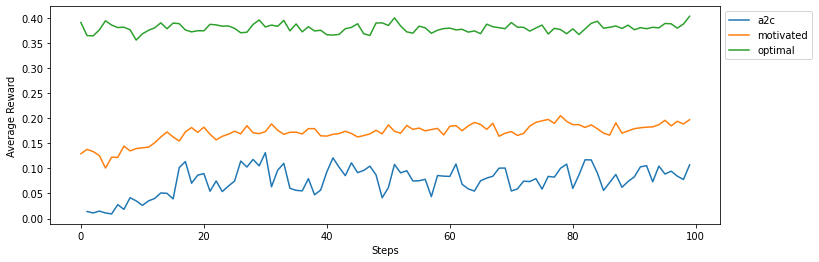

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(np.arange(learning_steps, training_iterations, learning_steps), a2c_rewards_all, label='a2c')
plt.plot(m_rewards_all, label='motivated')
plt.plot(o_rewards_all, label='optimal')

plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.show()

In [ ]:
zeros = np.linspace(0,0.99, 5)
zeros

array([0.  , 0.25, 0.49, 0.74, 0.99])

In [ ]:
learning_steps = 1
training_iterations = 100
max_steps = 100
# percent_zero = 0
learning_rate = 1
ent = 0.01

zeros = [0, 0.50, 0.9]

c = ['g','b','r']
zeros = np.linspace(0,0.99, 5)

m_all = []
o_all = []
a2c_all = []

for i, z in enumerate(zeros):
  
  m_rewards_all, o_rewards_all, a2c_rewards_all = run_multiple(episodes=2, percent_zero=z, learning_rate=1, ent=0)

  m_rewards_all = np.array(m_rewards_all).mean(axis=0)
  o_rewards_all = np.array(o_rewards_all).mean(axis=0)
  a2c_rewards_all = np.array(a2c_rewards_all).mean(axis=0)

  m_all.append(m_rewards_all)
  o_all.append(o_rewards_all)
  a2c_all.append(a2c_rewards_all)

 

/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py:87: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  "Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users."
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero en

ValueError: ignored

IndexError: ignored

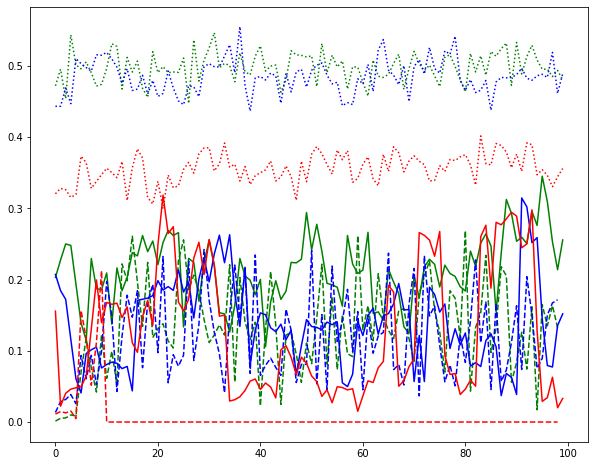

In [ ]:
for i in range(len(zeros)):

  plt.plot(o_all[i], c[i] + ':', label='optimal: ' + str(zeros[i]))
  plt.plot(m_all[i], c[i] + '-', label='motivated: ' + str(zeros[i]))
  plt.plot(a2c_all[i], c[i] + '--', label='a2c: ' + str(zeros[i]))

plt.xlim([0, max_steps])
  
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

  

In [ ]:
env = go.GoEnv(percent_zero=0.5)
env = gen_wrapped_env(env)
print(env.object_reward)

[0, 0, 0, 0, 0, -0.22671326429661454, -0.0847927944356508, 0.18535383565795116, -0.04028200222019396, 0.5708618338178251]


/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py:87: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  "Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users."


In [ ]:
learning_steps = 1
training_iterations = 100
max_steps = 100
episodes = 5

# c = ['g','b','r']
visited_prob = np.linspace(0,1,5)

m_all = []

for i, v in enumerate(visited_prob):
  m_rewards_all = []
  for i in range(episodes):
    motivated_rewards = run_agent(learning_steps=learning_steps, training_iterations=training_iterations, max_steps=max_steps, percent_zero=percent_zero, model='m', visited_prob=v)
    m_rewards_all.append(motivated_rewards)
    
  m_rewards_all = np.array(m_rewards_all).mean(axis=0)
  m_all.append(m_rewards_all)
  


/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py:87: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  "Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users."
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero en

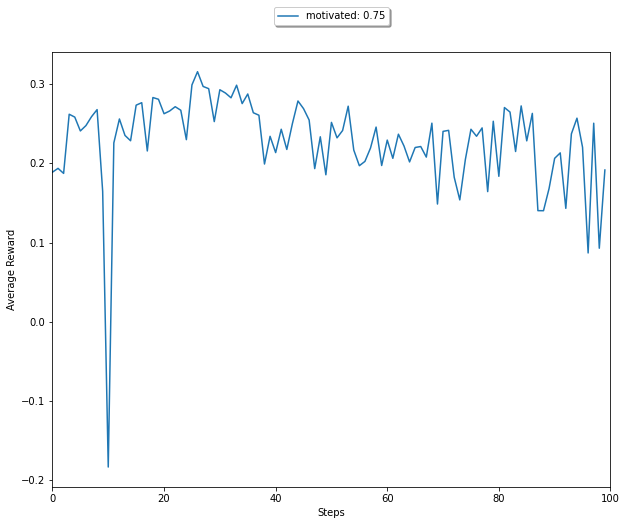

In [ ]:
for i in range(len(visited_prob[:-1])):
# for i in range(1):

  plt.plot(m_all[i], label='motivated: ' + str(visited_prob[i]))

plt.xlim([0, max_steps])
  
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)


In [ ]:
zeros = np.linspace(0,0.99,4)
zeros

array([0.  , 0.33, 0.66, 0.99])

In [ ]:
# Zeros
learning_steps = 1
training_iterations = 100
max_steps = 10
# percent_zero = 0
learning_rate = 1
ent = 0.01
episodes = 5
zeros = np.linspace(0,0.99, 5)

avg_m_reward = []
std_m_reward = []

avg_o_reward = []
std_o_reward = []

avg_a2c_reward = []
std_a2c_reward = []

avg_ppo_reward = []
std_ppo_reward = []

avg_dqn_reward = []
std_dqn_reward = []

for z in zeros:
  
  m_rewards_all, o_rewards_all, a2c_rewards_all, ppo_rewards_all, dqn_rewards_all = run_multiple(episodes=episodes, percent_zero=z, learning_rate=1, ent=0)
  avg_m_reward.append(np.mean(np.sum(m_rewards_all, axis = 1)))
  # avg_o_reward.append(np.mean(np.sum(o_rewards_all, axis = 1)))
  avg_a2c_reward.append(np.mean(np.sum(a2c_rewards_all, axis = 1)))
  # avg_ppo_reward.append(np.mean(np.sum(ppo_rewards_all, axis = 1)))
  # avg_dqn_reward.append(np.mean(np.sum(dqn_rewards_all, axis = 1)))

  std_m_reward.append(np.std(np.sum(m_rewards_all, axis = 1)))
  # std_o_reward.append(np.std(np.sum(o_rewards_all, axis = 1)))
  std_a2c_reward.append(np.std(np.sum(a2c_rewards_all, axis = 1)))
  # std_ppo_reward.append(np.std(np.sum(ppo_rewards_all, axis = 1)))
  # std_dqn_reward.append(np.std(np.sum(dqn_rewards_all, axis = 1)))



/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py:87: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  "Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users."
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py:87: UserWarning: WARN: Trying to mo

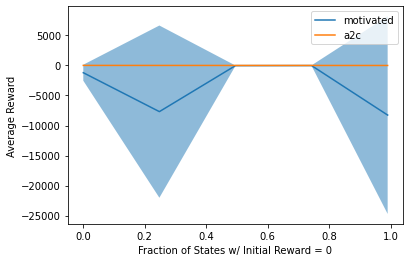

In [ ]:
avg_m_reward = np.array(avg_m_reward)
std_m_reward = np.array(std_m_reward)
# avg_o_reward = np.array(avg_o_reward)
# std_o_reward = np.array(std_o_reward)
avg_a2c_reward = np.array(avg_a2c_reward)
std_a2c_reward = np.array(std_a2c_reward)

# avg_ppo_reward = np.array(avg_ppo_reward)
# std_ppo_reward = np.array(std_ppo_reward)

# avg_dqn_reward = np.array(avg_dqn_reward)
# std_dqn_reward = np.array(std_dqn_reward)

plt.plot(zeros, avg_m_reward, label = 'motivated')
plt.fill_between(zeros, avg_m_reward - std_m_reward, avg_m_reward + std_m_reward,
                 alpha = 0.5)
# plt.plot(zeros, avg_o_reward, label = 'optimal')
# plt.fill_between(zeros, avg_o_reward - std_o_reward, avg_o_reward + std_o_reward,
#                  alpha = 0.5)
plt.plot(zeros, avg_a2c_reward, label = 'a2c')
plt.fill_between(zeros, avg_a2c_reward - std_a2c_reward, avg_a2c_reward + std_a2c_reward,
                 alpha = 0.5)
# plt.plot(zeros, avg_ppo_reward, label = 'ppo')
# plt.fill_between(zeros, avg_ppo_reward - std_ppo_reward, avg_ppo_reward + std_ppo_reward,
#                  alpha = 0.5)
# plt.plot(zeros, avg_dqn_reward, label = 'dqn')
# plt.fill_between(zeros, avg_dqn_reward - std_dqn_reward, avg_dqn_reward + std_dqn_reward,
#                  alpha = 0.5)
plt.legend(loc='upper right')
plt.xlabel('Fraction of States w/ Initial Reward = 0')
plt.ylabel('Average Reward')
plt.show()

In [ ]:
avg_m_reward

array([-1204.08, -7686.72,   -26.45,   -16.15, -8261.88])

In [ ]:
avg_a2c_reward

array([14.56,  9.22,  7.6 ,  6.59,  1.5 ])

In [ ]:
# visited probability
learning_steps = 1
training_iterations = 100
max_steps = 100
episodes = 5
percent_zero = 0

# c = ['g','b','r']
visited_prob = np.linspace(0,1,3)

m_all = []

avg_m_reward = []
std_m_reward = []

for i, v in enumerate(visited_prob):
  m_rewards_all = []
  for i in range(episodes):
    motivated_rewards = run_agent(learning_steps=learning_steps, training_iterations=training_iterations, max_steps=max_steps, percent_zero=percent_zero, model='m', visited_prob=v)
    m_rewards_all.append(motivated_rewards)
  
  avg_m_reward.append(np.mean(np.sum(m_rewards_all, axis = 1)))
  std_m_reward.append(np.std(np.sum(m_rewards_all, axis = 1)))

/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py:87: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  "Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users."
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py:87: UserWarning: WARN: Trying to mo

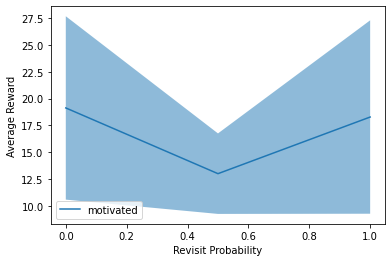

In [ ]:
avg_m_reward = np.array(avg_m_reward)
std_m_reward = np.array(std_m_reward)

plt.plot(visited_prob, avg_m_reward, label = 'motivated')
plt.fill_between(visited_prob, avg_m_reward - std_m_reward, avg_m_reward + std_m_reward,
                 alpha = 0.5)

plt.legend(loc='lower left')
plt.xlabel('Revisit Probability')
plt.ylabel('Average Reward')
plt.show()

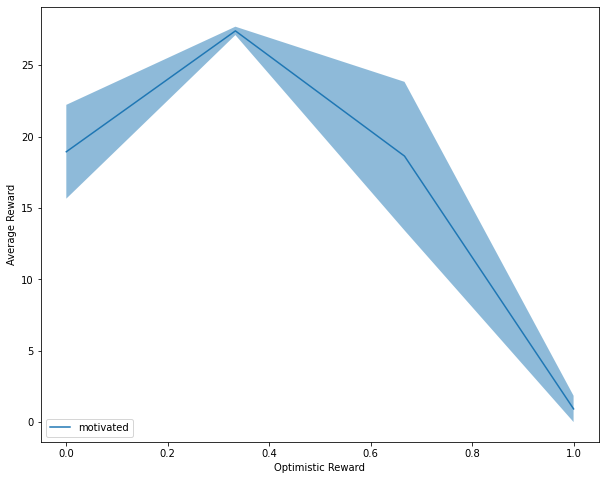

In [ ]:
avg_m_reward = np.array(m_all)
std_m_reward = np.array(m_all)

plt.plot(optimistic_rewards, avg_m_reward, label = 'motivated')
plt.fill_between(optimistic_rewards, avg_m_reward - std_m_reward, avg_m_reward + std_m_reward,
                 alpha = 0.5)

plt.legend(loc='lower left')
plt.xlabel('Optimistic Reward')
plt.ylabel('Average Reward')
plt.show()

In [ ]:
# motivation level
learning_steps = 1
training_iterations = 100
max_steps = 10
episodes = 100
v_prob = 0
o = 1
p_zero = 0

motivation_levels = np.linspace(0,3,10)

avg_m_reward = []
std_m_reward = []

avg_m_steps = []
std_m_steps = []

for i, ml in enumerate(motivation_levels):
  m_rewards_all = []
  num_steps_all = []
  for i in range(episodes):
    
    motivated_rewards, action_rewards, target = run_agent(learning_steps=learning_steps, training_iterations=training_iterations, max_steps=max_steps, percent_zero=percent_zero, model=model, visited_prob=v_prob, optimistic_reward=o, motivation_level=ml)
    m_rewards_all.append(motivated_rewards)
    num_steps_all.append(num_steps)
  avg_m_reward.append(np.mean(np.sum(m_rewards_all, axis = 0)))
  std_m_reward.append(np.std((np.sum(m_rewards_all, axis = 0))))

  avg_m_steps.append(np.mean(num_steps_all))
  std_m_steps.append(np.std(num_steps_all))


In [ ]:
avg_m_reward = np.array(avg_m_reward)
std_m_reward = np.array(std_m_reward)

avg_m_steps = np.array(avg_m_steps)
std_m_steps = np.array(std_m_steps)
print('avg steps:, ', avg_m_steps, 'std: ', std_m_steps)
plt.plot(motivation_levels, avg_m_steps, label = 'motivated')
plt.fill_between(motivation_levels, avg_m_steps - std_m_steps, avg_m_steps + std_m_steps,
                 alpha = 0.5)

plt.legend(loc='lower left')
plt.xlabel('Motivation Level')
plt.ylabel('Average Number of Steps')
plt.show()

In [ ]:
# learning Rate
learning_steps = 1
training_iterations = 100
max_steps = 100
episodes = 5
percent_zero = 0
learning_rate = 1
ent=0
# run_a2c_agent(save_frequency, iterations, max_steps, percent_zero=0, learning_rate=0.0007, ent=0.01):

# c = ['g','b','r']
learning_rates = np.linspace(0,1,5)
entropy = np.linspace(0,1,5)
a2c_all = []

avg_a2c_reward = []
std_a2c_reward = []

for i, e in enumerate(entropy):

  a2c_rewards_all = []
  for i in range(episodes):
    a2c_rewards = run_a2c_agent(learning_steps, training_iterations, max_steps, learning_rate=learning_rate, percent_zero=percent_zero, ent=e)
    a2c_rewards_all.append(a2c_rewards)

  avg_a2c_reward.append(np.mean(np.sum(a2c_rewards_all, axis = 1)))
  std_a2c_reward.append(np.std(np.sum(a2c_rewards_all, axis = 1)))

/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py:87: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  "Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py:87: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  "Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py:87: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it

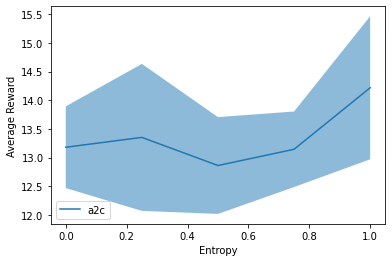

In [ ]:
avg_a2c_reward = np.array(avg_a2c_reward)
std_a2c_reward = np.array(std_a2c_reward)

plt.plot(entropy, avg_a2c_reward, label = 'a2c')
plt.fill_between(entropy, avg_a2c_reward - std_a2c_reward, avg_a2c_reward + std_a2c_reward,
                 alpha = 0.5)
plt.legend(loc='lower left')
plt.xlabel('Entropy')
plt.ylabel('Average Reward')
plt.show()

In [ ]:
print(zero_avg)
print(zero_std)

print(half_avg)
print(half_std)

print(ninety_avg)
print(ninety_std)

[ 0.56 14.03 13.16 14.1  13.44]
[0.35 1.05 0.75 0.92 0.73]
[1.94 7.97 4.81 6.05 0.2 ]
[3.88 6.37 5.79 7.41 0.38]
[0.   0.   0.   2.02 0.  ]
[0.   0.   0.   4.03 0.  ]


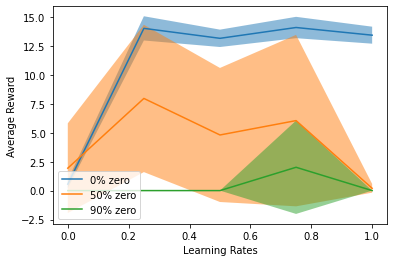

In [ ]:
plt.plot(learning_rates, zero_avg, label = '0% zero')
plt.fill_between(learning_rates, zero_avg - zero_std, zero_avg + zero_std,
                 alpha = 0.5)

plt.plot(learning_rates, half_avg, label = '50% zero')
plt.fill_between(learning_rates, half_avg - half_std, half_avg + half_std,
                 alpha = 0.5)

plt.plot(learning_rates, ninety_avg, label = '90% zero')
plt.fill_between(learning_rates, ninety_avg - ninety_std, ninety_avg + ninety_std,
                 alpha = 0.5)

plt.legend(loc='lower left')
plt.xlabel('Learning Rates')
plt.ylabel('Average Reward')
plt.show()